In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/bank_cleaned.csv'
data = pd.read_csv(file_path, index_col='Unnamed: 0')
data

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
5,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
6,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,505,no,yes,17,nov,6.43,2,-1,0,unknown,yes,1
45206,51,technician,married,tertiary,no,825,no,no,17,nov,16.28,3,-1,0,unknown,yes,1
45207,71,retired,divorced,primary,no,1729,no,no,17,nov,7.60,2,-1,0,unknown,yes,1
45208,72,retired,married,secondary,no,5715,no,no,17,nov,18.78,5,184,3,success,yes,1


#Featuer ENG

In [4]:

X = data.drop('response_binary', axis=1)
y = data['response_binary']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# One-hot encode categorical variables
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome', 'response']
data = pd.get_dummies(data, columns=categorical_columns)

# Scale numerical variables
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Creating a new binary feature based on 'balance'
median_balance = data['balance'].median()
data['high_balance'] = (data['balance'] > median_balance).astype(int)

# Display the first few rows to verify changes
data.head()


,age,balance,day,duration,campaign,pdays,previous,response_binary,job_admin.,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success,poutcome_unknown,response_no,response_yes,high_balance
0,1.642841,0.624231,-1.306749,0.009534,-0.571543,-0.366424,-0.2778,0,False,False,...,True,False,False,False,False,False,True,True,False,1
1,0.306369,-0.610196,-1.306749,-0.415477,-0.571543,-0.366424,-0.2778,0,False,False,...,True,False,False,False,False,False,True,True,False,0
2,-0.743715,-0.625962,-1.306749,-0.705785,-0.571543,-0.366424,-0.2778,0,False,False,...,True,False,False,False,False,False,True,True,False,0
5,-0.552791,-0.492242,-1.306749,-0.461926,-0.571543,-0.366424,-0.2778,0,False,False,...,True,False,False,False,False,False,True,True,False,0
6,-1.221027,-0.366113,-1.306749,-0.160006,-0.571543,-0.366424,-0.2778,0,False,False,...,True,False,False,False,False,False,True,True,False,1


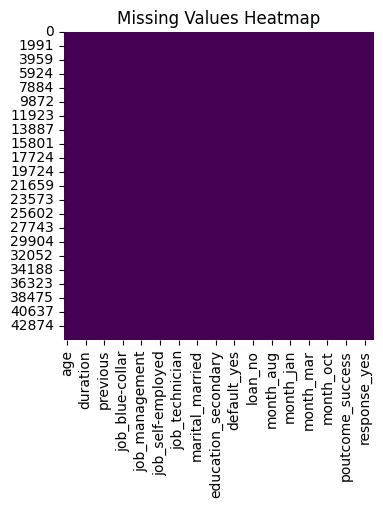

In [6]:
# Check for missing values
plt.figure(figsize=(4, 4))
sns.heatmap(data.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

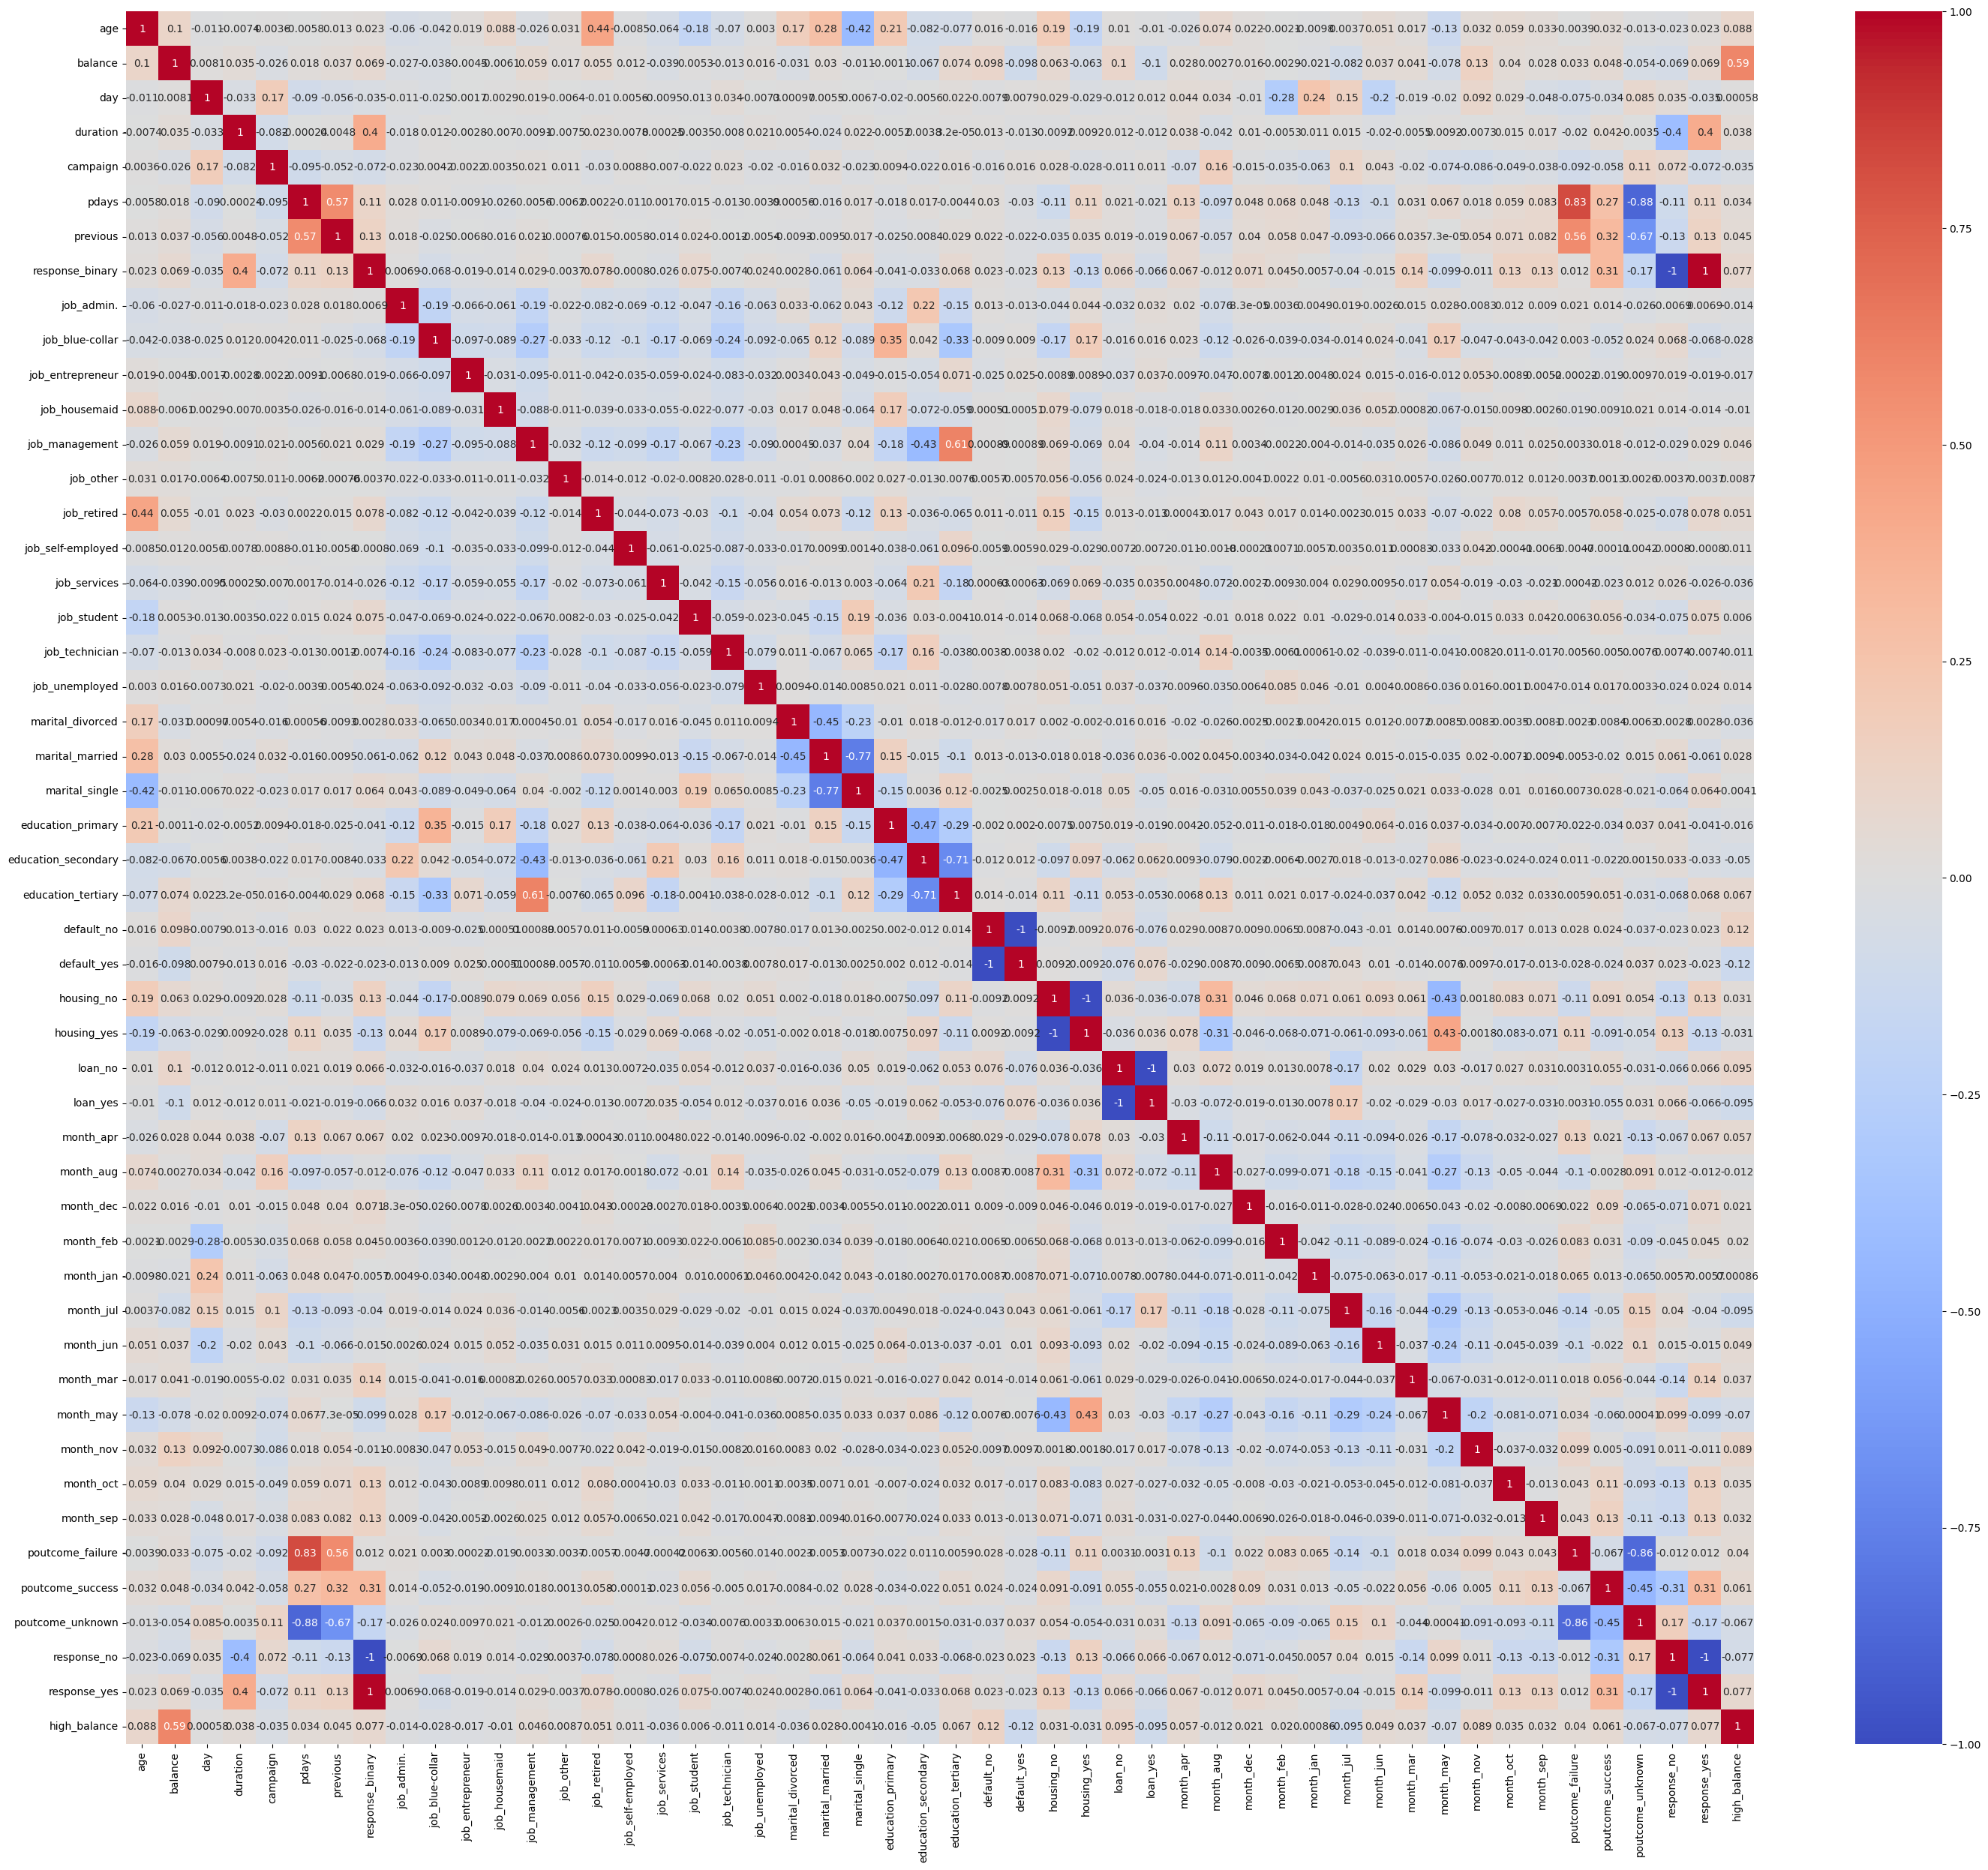

In [7]:
# Explore correlation between features
correlation_matrix = data.corr()
plt.figure(figsize=(35, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#Baseline Model with over and under sampling
# First try

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7166
           1       1.00      1.00      1.00      1003

    accuracy                           1.00      8169
   macro avg       1.00      1.00      1.00      8169
weighted avg       1.00      1.00      1.00      8169

Baseline ROC-AUC: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Oversampling Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7166
           1       1.00      1.00      1.00      1003

    accuracy                           1.00      8169
   macro avg       1.00      1.00      1.00      8169
weighted avg       1.00      1.00      1.00      8169

Oversampled ROC-AUC: 1.0
Undersampling Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7166
           1       1.00      1.00      1.00      1003

    accuracy                           1.00      8169
   macro avg       1.00      1.00      1.00      8169
weighted avg       1.00      1.00      1.00      8169

Undersampled ROC-AUC: 1.0


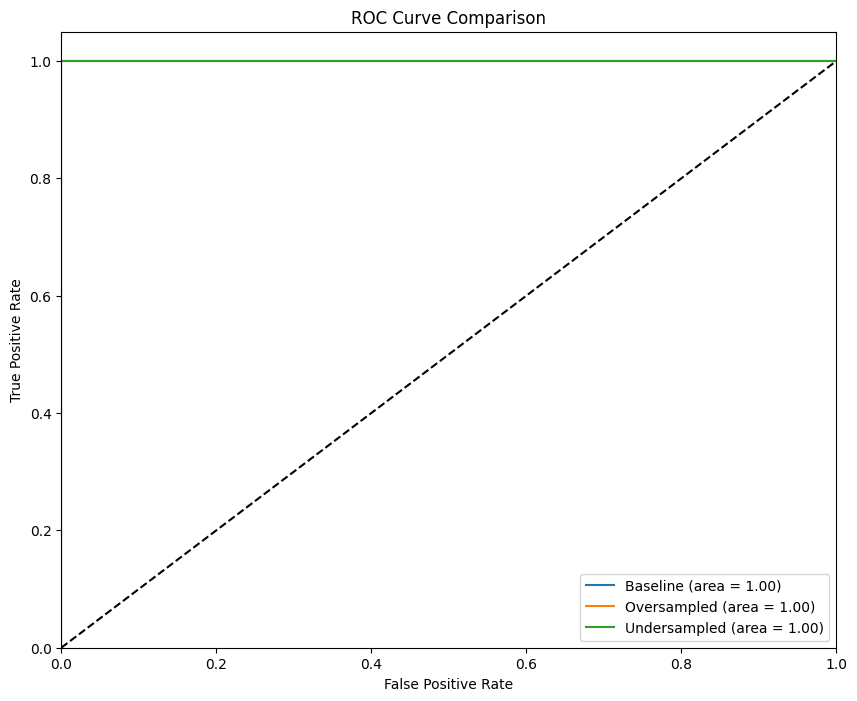

In [8]:



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Prepare the data
X = data.drop('response_binary', axis=1)
y = data['response_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model
logreg = LogisticRegression(max_iter=20)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Evaluate Baseline Model
print("Baseline Model Evaluation:")
print(classification_report(y_test, y_pred))
baseline_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f"Baseline ROC-AUC: {baseline_roc_auc}")

# Oversampling
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
logreg.fit(X_sm, y_sm)
y_pred_sm = logreg.predict(X_test)

# Evaluate Oversampling Model
print("Oversampling Model Evaluation:")
print(classification_report(y_test, y_pred_sm))
oversample_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f"Oversampled ROC-AUC: {oversample_roc_auc}")

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
logreg.fit(X_rus, y_rus)
y_pred_rus = logreg.predict(X_test)

# Evaluate Undersampling Model
print("Undersampling Model Evaluation:")
print(classification_report(y_test, y_pred_rus))
undersample_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f"Undersampled ROC-AUC: {undersample_roc_auc}")

# ROC Curve Comparison
plt.figure(figsize=(10, 8))
for (model, y_pred_proba, label) in [
    (logreg, logreg.predict_proba(X_test)[:, 1], 'Baseline'),
    (logreg, logreg.predict_proba(X_test)[:, 1], 'Oversampled'),
    (logreg, logreg.predict_proba(X_test)[:, 1], 'Undersampled')
]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{label} (area = {roc_auc_score(y_test, y_pred_proba):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


# The Model after solving overfiting

Accuracy: 0.8849, F1 Score: 0.2645, ROC AUC: 0.8423


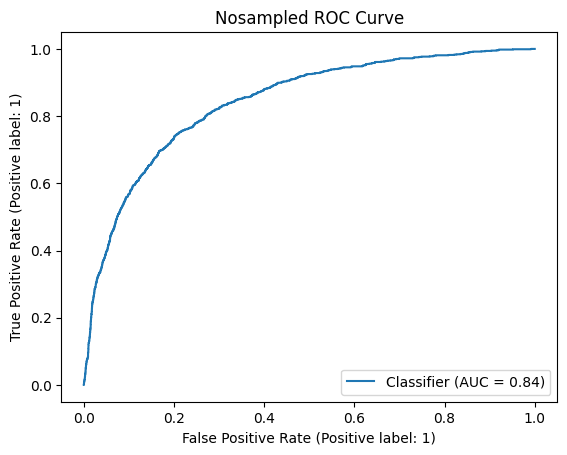

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt



# Separate features and target
X = data.drop('response_binary', axis=1)
y = data['response_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create the preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines the preprocessor with the logistic regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegressionCV(cv=5, max_iter=1000, random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
prob_predictions = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, prob_predictions)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, prob_predictions)
plt.title('Nosampled ROC Curve')
plt.show()


Accuracy: 0.8892, F1 Score: 0.5127, ROC AUC: 0.8843


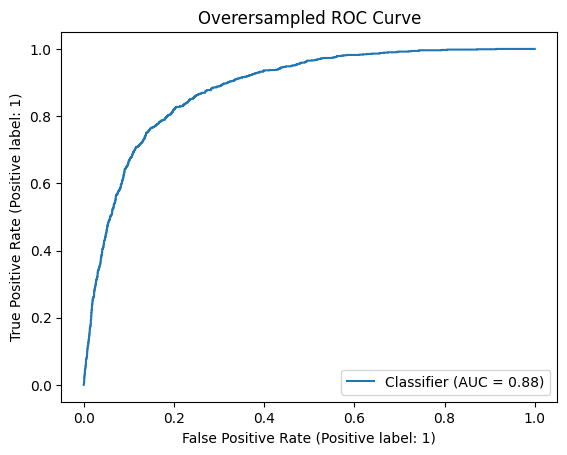

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt



X = data.drop('response_binary', axis=1)
y = data['response_binary']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(), X.select_dtypes(include=['object', 'category']).columns)
    ])

# XGBoost model within a pipeline
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Displaying metrics
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Plotting ROC Curve
RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test)[:, 1])
plt.title('Overersampled ROC Curve')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.9400, F1 Score: 0.9483, ROC AUC: 0.9859


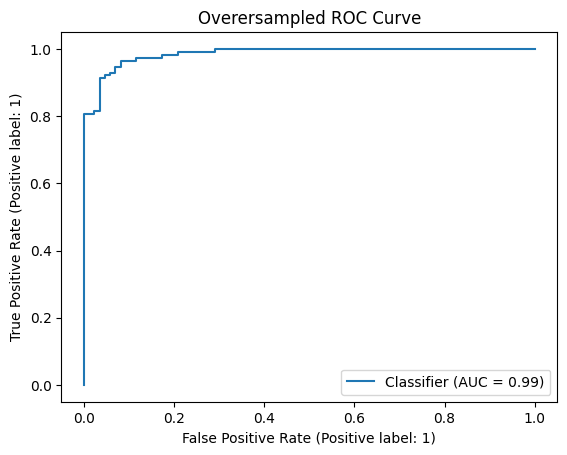

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline

X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10,
                           n_clusters_per_class=1, weights=[0.4], flip_y=0, random_state=42)
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y = pd.Series(y, name='response_binary')

# Assume the first 10 features are numeric and the next 10 are categorical (encoded as numeric for simplicity)
X.iloc[:, 10:] = X.iloc[:, 10:].applymap(lambda x: str(int(x)))

# Separate features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical and categorical columns
numerical_features = X.columns[:10].tolist()
categorical_features = X.columns[10:].tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with SMOTE and Logistic Regression
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=3)),
    ('classifier', LogisticRegressionCV(cv=3, max_iter=20
                                        , random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
prob_predictions = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, prob_predictions)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, prob_predictions)
plt.title('Overersampled ROC Curve')
plt.show()


Accuracy: 0.8057, F1 Score: 0.4761, ROC AUC: 0.8454


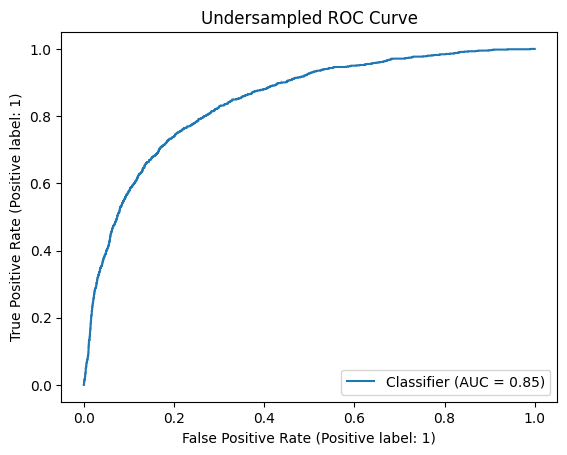

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt



# Separate features and target
X = data.drop('response_binary', axis=1)
y = data['response_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing, RandomUnderSampler, and Logistic Regression
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegressionCV(cv=5, max_iter=1000, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
prob_predictions = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, prob_predictions)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, prob_predictions)
plt.title('Undersampled ROC Curve')
plt.show()


In [2]:
!pip install mvlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of seaborn to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.8 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11685503 sha256=1366b4514a021e6e293094c997a179f8c8b31f23e5bc2fc590de0bf1c4728e31
  Stored in directory: /root/.cache/pip/wheels/38/c6/49/eaba6d234887d98d9c85185e2a90bd7bb77934e85eefaf317e
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting un

In [9]:
data.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'response_binary', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_other', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_success', 'poutcome_unknown',
       'response_no', 'response_yes', 'high_balance'],
      dtype='object')

In [12]:
from mvlearn.semi_supervised import CTClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mvlearn.semi_supervised import CTClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import numpy as np


# Define views as per previous setup
view1_columns = ['age', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
                 'job_housemaid', 'job_management', 'job_other', 'job_retired',
                 'job_self-employed', 'job_services', 'job_student', 'job_technician',
                 'job_unemployed', 'marital_divorced', 'marital_married',
                 'marital_single', 'education_primary', 'education_secondary',
                 'education_tertiary']

view2_columns = ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
                 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no',
                 'loan_yes', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
                 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
                 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
                 'poutcome_success', 'poutcome_unknown', 'high_balance']

X_view1 = X[view1_columns]
X_view2 = X[view2_columns]



y_labels = y.copy()



# Co with under and over sampling  two diff estimator

Training with No Sampling...
Sampling Strategy: No Sampling
ROC-AUC: 0.8699146768458232, Accuracy: 0.8862773901334313, F1-Score: 0.21204410517387617, Runtime: 1.986480712890625s

Training with SMOTE...
Sampling Strategy: SMOTE
ROC-AUC: 0.9035864775197153, Accuracy: 0.8942343004039662, F1-Score: 0.521594684385382, Runtime: 7.055190801620483s

Training with RandomUnderSampler...
Sampling Strategy: RandomUnderSampler
ROC-AUC: 0.8748830260544072, Accuracy: 0.8106255355612683, F1-Score: 0.5077951002227171, Runtime: 1.4116709232330322s



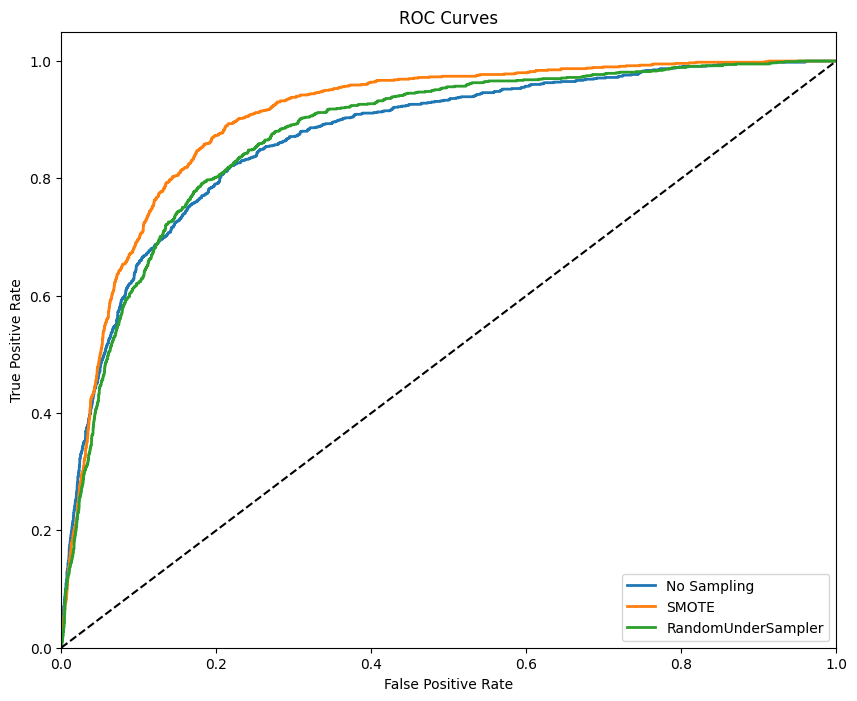

Statistical Comparison (Runtime):
TtestResult(statistic=nan, pvalue=nan, df=0.0)
TtestResult(statistic=nan, pvalue=nan, df=0.0)
TtestResult(statistic=nan, pvalue=nan, df=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mvlearn.semi_supervised import CTClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind


# Split the dataset
X_train_view1, X_test_view1, y_train, y_test = train_test_split(X_view1, y, test_size=0.2, random_state=42)
X_train_view2, X_test_view2 = train_test_split(X_view2, test_size=0.2, random_state=42)[0:2]

def train_ct_classifier(X_train_views, y_train, X_test_views, y_test, sampling_strategy=None):
    # Apply sampling strategy if provided
    if sampling_strategy is not None:
        X_train_combined = np.hstack(X_train_views)
        X_train_combined, y_train = sampling_strategy.fit_resample(X_train_combined, y_train)
        split_index = X_train_views[0].shape[1]
        X_train_views = [X_train_combined[:, :split_index], X_train_combined[:, split_index:]]

    # Define different estimators for each view
    estimator1 = RandomForestClassifier(random_state=42, n_jobs=-1)
    estimator2 = LogisticRegression(max_iter=1000, random_state=42)

    # Initialize and fit the CTClassifier
    start_time = time.time()
    ct_classifier = CTClassifier(estimator1=estimator1, estimator2=estimator2, random_state=42)
    ct_classifier.fit(X_train_views, y_train)
    fit_time = time.time() - start_time

    # Evaluate the model
    y_pred = ct_classifier.predict(X_test_views)
    y_pred_proba = ct_classifier.predict_proba(X_test_views)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Sampling Strategy: {sampling_strategy.__class__.__name__ if sampling_strategy else 'No Sampling'}")
    print(f"ROC-AUC: {roc_auc}, Accuracy: {accuracy}, F1-Score: {f1}, Runtime: {fit_time}s\n")

    return y_test, y_pred_proba, fit_time

# Plot ROC Curve
def plot_roc_curve(y_test, y_pred_probas, labels):
    plt.figure(figsize=(10, 8))
    for y_pred_proba, label in zip(y_pred_probas, labels):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Statistical Comparison
def compare_model_performances(times):


    print("Statistical Comparison (Runtime):")
    print(ttest_ind(times['No Sampling'], times['SMOTE']))
    print(ttest_ind(times['No Sampling'], times['RandomUnderSampler']))
    print(ttest_ind(times['SMOTE'], times['RandomUnderSampler']))

# Training and evaluating
strategies = [None, SMOTE(random_state=42), RandomUnderSampler(random_state=42)]
strategy_labels = ['No Sampling', 'SMOTE', 'RandomUnderSampler']
y_pred_probas = []
times = {label: [] for label in strategy_labels}

for strategy, label in zip(strategies, strategy_labels):
    print(f"Training with {label}...")
    y_test, y_pred_proba, runtime = train_ct_classifier([X_train_view1, X_train_view2], y_train, [X_test_view1, X_test_view2], y_test, sampling_strategy=strategy)
    y_pred_probas.append(y_pred_proba)
    times[label].append(runtime)

# Plotting ROC Curves
plot_roc_curve(y_test, y_pred_probas, strategy_labels)

# Perform statistical comparison
compare_model_performances(times)


# Same estimators





Training with No Sampling...
Sampling Strategy: No Sampling
ROC-AUC: 0.8962534667835733, Accuracy: 0.8854204921042967, F1-Score: 0.18608695652173912, Runtime: 1.7646162509918213s

Training with SMOTE...
Sampling Strategy: SMOTE
ROC-AUC: 0.9062327391256317, Accuracy: 0.8495531888848085, F1-Score: 0.5683175272216368, Runtime: 1.2552235126495361s

Training with RandomUnderSampler...
Sampling Strategy: RandomUnderSampler
ROC-AUC: 0.907178965475886, Accuracy: 0.844044558697515, F1-Score: 0.5621993127147766, Runtime: 1.132936954498291s



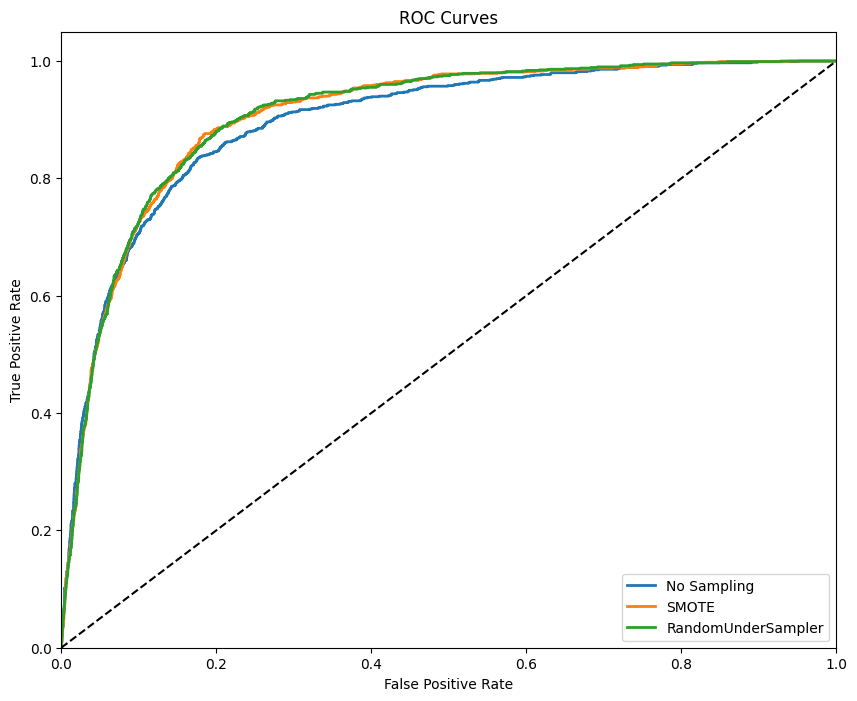

Statistical Comparison (Runtime):
TtestResult(statistic=nan, pvalue=nan, df=0.0)
TtestResult(statistic=nan, pvalue=nan, df=0.0)
TtestResult(statistic=nan, pvalue=nan, df=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mvlearn.semi_supervised import CTClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind


# Split the dataset
X_train_view1, X_test_view1, y_train, y_test = train_test_split(X_view1, y, test_size=0.2, random_state=42)
X_train_view2, X_test_view2 = train_test_split(X_view2, test_size=0.2, random_state=42)[0:2]

def train_ct_classifier(X_train_views, y_train, X_test_views, y_test, sampling_strategy=None):
    # Apply sampling strategy if provided
    if sampling_strategy is not None:
        X_train_combined = np.hstack(X_train_views)
        X_train_combined, y_train = sampling_strategy.fit_resample(X_train_combined, y_train)
        split_index = X_train_views[0].shape[1]
        X_train_views = [X_train_combined[:, :split_index], X_train_combined[:, split_index:]]

    # Define different estimators for each view
    estimator1 = LogisticRegression(random_state=42, n_jobs=-1)
    estimator2 = LogisticRegression(max_iter=1000, random_state=42)

    # Initialize and fit the CTClassifier
    start_time = time.time()
    ct_classifier = CTClassifier(estimator1=estimator1, estimator2=estimator2, random_state=42)
    ct_classifier.fit(X_train_views, y_train)
    fit_time = time.time() - start_time

    # Evaluate the model
    y_pred = ct_classifier.predict(X_test_views)
    y_pred_proba = ct_classifier.predict_proba(X_test_views)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Sampling Strategy: {sampling_strategy.__class__.__name__ if sampling_strategy else 'No Sampling'}")
    print(f"ROC-AUC: {roc_auc}, Accuracy: {accuracy}, F1-Score: {f1}, Runtime: {fit_time}s\n")

    return y_test, y_pred_proba, fit_time

# Plot ROC Curve
def plot_roc_curve(y_test, y_pred_probas, labels):
    plt.figure(figsize=(10, 8))
    for y_pred_proba, label in zip(y_pred_probas, labels):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Statistical Comparison
def compare_model_performances(times):

    print("Statistical Comparison (Runtime):")
    print(ttest_ind(times['No Sampling'], times['SMOTE']))
    print(ttest_ind(times['No Sampling'], times['RandomUnderSampler']))
    print(ttest_ind(times['SMOTE'], times['RandomUnderSampler']))

# Training and evaluating
strategies = [None, SMOTE(random_state=42), RandomUnderSampler(random_state=42)]
strategy_labels = ['No Sampling', 'SMOTE', 'RandomUnderSampler']
y_pred_probas = []
times = {label: [] for label in strategy_labels}

for strategy, label in zip(strategies, strategy_labels):
    print(f"Training with {label}...")
    y_test, y_pred_proba, runtime = train_ct_classifier([X_train_view1, X_train_view2], y_train, [X_test_view1, X_test_view2], y_test, sampling_strategy=strategy)
    y_pred_probas.append(y_pred_proba)
    times[label].append(runtime)

# Plotting ROC Curves
plot_roc_curve(y_test, y_pred_probas, strategy_labels)

# Perform statistical comparison
compare_model_performances(times)


# Evaluation part






In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mvlearn.semi_supervised import CTClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import time

# Assuming X_view1 and X_view2
X_view1 = data[view1_columns].values
X_view2 = data[view2_columns].values
y = data['response_binary'].values

# Split the dataset into training and testing sets
X_train_view1, X_test_view1, y_train, y_test = train_test_split(X_view1, y, test_size=0.2, random_state=42)
X_train_view2, X_test_view2 = train_test_split(X_view2, test_size=0.2, random_state=42)[0:2]

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

def evaluate_model_with_sampling_and_labels(X_train_views, y_train, X_test_views, y_test, labeled_percentage, sampling_strategy=None):
    np.random.seed(42)  # Ensure reproducibility
    total_samples = len(y_train)
    labeled_indices = np.random.choice(total_samples, size=int(total_samples * labeled_percentage), replace=False)

    # Extract the labeled subset based on the current strategy
    X_train_views_subset = [X_view[labeled_indices] for X_view in X_train_views]
    y_train_subset = y_train[labeled_indices]

    # Apply sampling strategy if provided
    if sampling_strategy is not None:
        X_train_combined_subset = np.hstack(X_train_views_subset)
        X_train_resampled, y_train_resampled = sampling_strategy.fit_resample(X_train_combined_subset, y_train_subset)
        # Split back into views after resampling
        split_index = X_train_views_subset[0].shape[1]
        X_train_views_subset = [X_train_resampled[:, :split_index], X_train_resampled[:, split_index:]]
        y_train_subset = y_train_resampled

    # Train and evaluate the CTClassifier
    start_time = time.time()
    ct_classifier = CTClassifier(estimator1=RandomForestClassifier(random_state=42, n_jobs=-1),
                                 estimator2=LogisticRegression(max_iter=1000, random_state=42),
                                 random_state=42)
    ct_classifier.fit(X_train_views_subset, y_train_subset)
    y_pred_proba = ct_classifier.predict_proba(X_test_views)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    elapsed_time = time.time() - start_time

    sampling_label = "No Sampling" if sampling_strategy is None else sampling_strategy.__class__.__name__
    print(f"{sampling_label} with {labeled_percentage*100:.0f}% labeled data: ROC-AUC = {roc_auc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

# Define sampling strategies
sampling_strategies = [None, SMOTE(random_state=42), RandomUnderSampler(random_state=42)]

# Evaluate the model across different levels of labeled data and sampling strategies
labeled_percentages = [1.0, 0.5, 0.25, 0.1, 0.05, 0.01]
for sampling_strategy in sampling_strategies:
    for labeled_percentage in labeled_percentages:
        evaluate_model_with_sampling_and_labels([X_train_view1, X_train_view2], y_train, [X_test_view1, X_test_view2], y_test, labeled_percentage, sampling_strategy=sampling_strategy)


No Sampling with 100% labeled data: ROC-AUC = 0.8703, Elapsed Time: 2.89 seconds
No Sampling with 50% labeled data: ROC-AUC = 0.8614, Elapsed Time: 2.50 seconds
No Sampling with 25% labeled data: ROC-AUC = 0.8485, Elapsed Time: 1.08 seconds
No Sampling with 10% labeled data: ROC-AUC = 0.8356, Elapsed Time: 0.66 seconds
No Sampling with 5% labeled data: ROC-AUC = 0.8302, Elapsed Time: 0.54 seconds
No Sampling with 1% labeled data: ROC-AUC = 0.8045, Elapsed Time: 0.40 seconds
SMOTE with 100% labeled data: ROC-AUC = 0.9044, Elapsed Time: 5.80 seconds
SMOTE with 50% labeled data: ROC-AUC = 0.9031, Elapsed Time: 5.39 seconds
SMOTE with 25% labeled data: ROC-AUC = 0.8945, Elapsed Time: 1.51 seconds
SMOTE with 10% labeled data: ROC-AUC = 0.8765, Elapsed Time: 0.82 seconds
SMOTE with 5% labeled data: ROC-AUC = 0.8664, Elapsed Time: 0.64 seconds
SMOTE with 1% labeled data: ROC-AUC = 0.8194, Elapsed Time: 0.45 seconds
RandomUnderSampler with 100% labeled data: ROC-AUC = 0.8730, Elapsed Time: 0.8

No Sampling with 100% labeled data: Accuracy = 0.8862, F1-Score = 0.2159, ROC-AUC = 0.8703, Elapsed Time: 1.90 seconds
No Sampling with 50% labeled data: Accuracy = 0.8851, F1-Score = 0.2089, ROC-AUC = 0.8614, Elapsed Time: 1.21 seconds
No Sampling with 25% labeled data: Accuracy = 0.8862, F1-Score = 0.2172, ROC-AUC = 0.8485, Elapsed Time: 0.96 seconds
No Sampling with 10% labeled data: Accuracy = 0.8882, F1-Score = 0.2571, ROC-AUC = 0.8356, Elapsed Time: 0.30 seconds
No Sampling with 5% labeled data: Accuracy = 0.8877, F1-Score = 0.2587, ROC-AUC = 0.8302, Elapsed Time: 0.34 seconds
No Sampling with 1% labeled data: Accuracy = 0.8849, F1-Score = 0.1883, ROC-AUC = 0.8045, Elapsed Time: 0.13 seconds
SMOTE with 100% labeled data: Accuracy = 0.8947, F1-Score = 0.5212, ROC-AUC = 0.9044, Elapsed Time: 6.02 seconds
SMOTE with 50% labeled data: Accuracy = 0.8948, F1-Score = 0.5105, ROC-AUC = 0.9031, Elapsed Time: 2.43 seconds
SMOTE with 25% labeled data: Accuracy = 0.8891, F1-Score = 0.4841, R

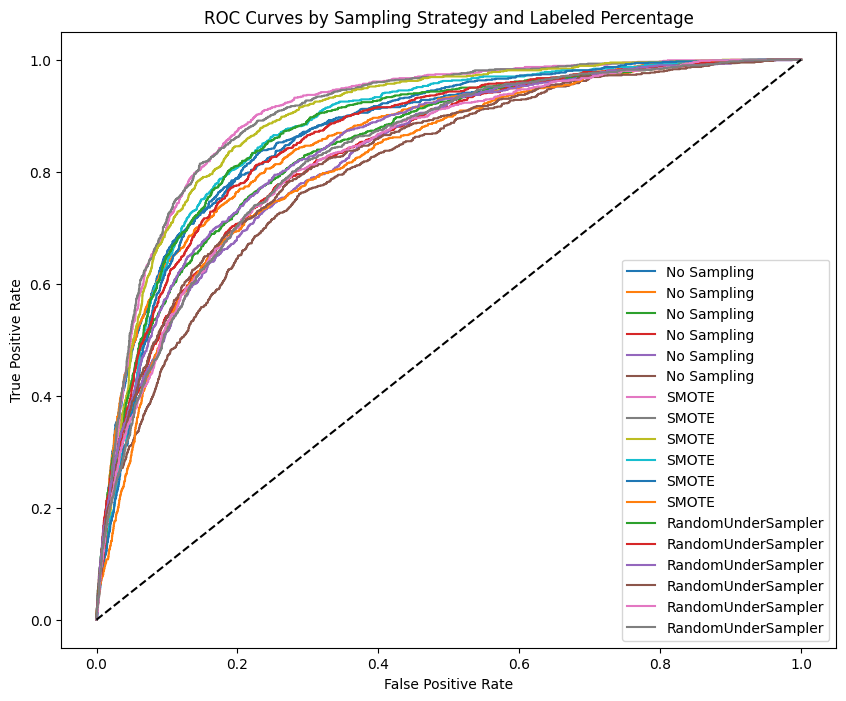

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mvlearn.semi_supervised import CTClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import time


# Function to evaluate the model
def evaluate_model_with_sampling_and_labels(X_train_views, y_train, X_test_views, y_test, labeled_percentage, sampling_strategy=None):
    np.random.seed(42)
    total_samples = len(y_train)
    labeled_indices = np.random.choice(total_samples, size=int(total_samples * labeled_percentage), replace=False)

    # Create training subsets based on labeled indices
    X_train_views_subset = [X_view[labeled_indices] for X_view in X_train_views]
    y_train_subset = y_train[labeled_indices]

    # Apply sampling strategy if provided
    if sampling_strategy is not None:
        X_train_combined_subset = np.hstack(X_train_views_subset)
        X_train_resampled, y_train_resampled = sampling_strategy.fit_resample(X_train_combined_subset, y_train_subset)
        # Split back into views after resampling
        split_index = X_train_views_subset[0].shape[1]
        X_train_views_subset = [X_train_resampled[:, :split_index], X_train_resampled[:, split_index:]]
        y_train_subset = y_train_resampled

    # Initialize and fit the CTClassifier
    start_time = time.time()
    ct_classifier = CTClassifier(estimator1=RandomForestClassifier(random_state=42),
                                 estimator2=LogisticRegression(max_iter=1000, random_state=42),
                                 random_state=42)
    ct_classifier.fit(X_train_views_subset, y_train_subset)

    # Evaluation
    elapsed_time = time.time() - start_time
    y_pred = ct_classifier.predict(X_test_views)
    y_pred_proba = ct_classifier.predict_proba(X_test_views)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    sampling_label = sampling_strategy.__class__.__name__ if sampling_strategy else "No Sampling"
    print(f"{sampling_label} with {labeled_percentage*100:.0f}% labeled data: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

    return y_test, y_pred_proba, sampling_label

# Collect results for ROC curve plotting
roc_results = []

# Define sampling strategies and labeled percentages
sampling_strategies = [None, SMOTE(random_state=42), RandomUnderSampler(random_state=42)]
labeled_percentages = [1.0, 0.5, 0.25, 0.1, 0.05, 0.01]

for sampling_strategy in sampling_strategies:
    for labeled_percentage in labeled_percentages:
        roc_results.append(evaluate_model_with_sampling_and_labels([X_train_view1, X_train_view2], y_train, [X_test_view1, X_test_view2], y_test, labeled_percentage, sampling_strategy))

# Plot ROC Curves for each strategy and labeled percentage
plt.figure(figsize=(10, 8))
for y_test, y_pred_proba, label in roc_results:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{label}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Sampling Strategy and Labeled Percentage')
plt.legend(loc="lower right")
plt.show()


#  semi-supervised ensemble




In [34]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

# For demonstration, creating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
data = pd.DataFrame(X)
data['response_binary'] = y

# Splitting features and target
X = data.drop('response_binary', axis=1)
y = data['response_binary']

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Semi-supervised learning setup: Split the training data into labeled and unlabeled datasets
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=42)

# Define base classifiers
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Wrap each base classifier with SelfTrainingClassifier and add to the ensemble
ensemble = []
for name, clf in base_classifiers:
    st_clf = SelfTrainingClassifier(clf, criterion='k_best', k_best=50)
    ensemble.append((name, st_clf))

# Define the ensemble model with soft voting
voting_clf = VotingClassifier(estimators=ensemble, voting='soft')

# Fit the ensemble model on the labeled data
voting_clf.fit(X_labeled, y_labeled)

# Evaluate the ensemble model on the test set
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Accuracy: 0.8700, F1 Score: 0.8632, ROC AUC: 0.9502


Processing none strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

       Strategy  Label Ratio  Accuracy  F1 Score  ROC AUC  Runtime (s)
0          none         0.50     0.915  0.916256    0.915     0.019033
1          none         0.25     0.915  0.915423    0.915     0.013718
2          none         0.10     0.920  0.920000    0.920     0.013824
3          none         0.05     0.915  0.916256    0.915     0.013477
4          none         0.01     0.925  0.926829    0.925     0.014118
5    oversample         0.50     0.905  0.906404    0.905     0.015022
6    oversample         0.25     0.910  0.910891    0.910     0.021703
7    oversample         0.10     0.905  0.905473    0.905     0.013582
8    oversample         0.05     0.920  0.920792    0.920     0.020711
9    oversample         0.01     0.920  0.921569    0.920     0.013952
10  undersample         0.50     0.905  0.906404    0.905     0.013694
11  undersample         0.25     0.920  0.920000    0.920     0.013828
12  undersample         0.10     0.905  0.904523    0.905     0.013757
13  un

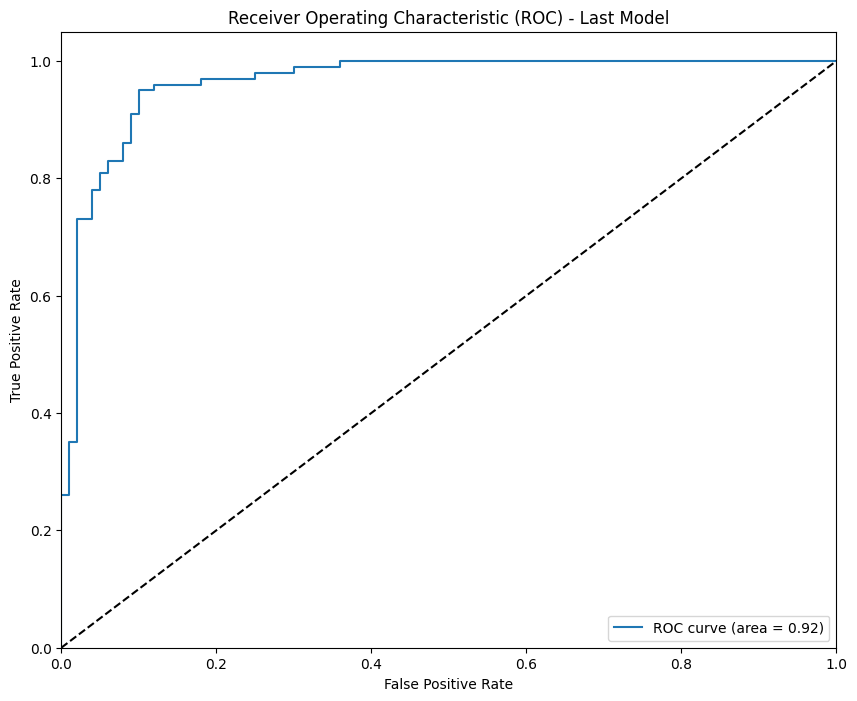

In [42]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from scipy import stats
import time

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.utils import resample

def apply_sampling(strategy, X, y):
    if strategy == 'oversample':
        class_counts = np.bincount(y)
        smallest_class_size = np.min(class_counts[class_counts > 0])
        k_neighbors = max(1, min(smallest_class_size - 1, 5))
        try:
            sampler = SMOTE(k_neighbors=k_neighbors, random_state=42)
            X_res, y_res = sampler.fit_resample(X, y)
        except ValueError:
            print("Fallback: Resampling without SMOTE due to small class size.")
            X_res, y_res = resample(X, y, replace=False, n_samples=len(y), random_state=42)
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
        X_res, y_res = sampler.fit_resample(X, y)
    else:
        return X, y
    return X_res, y_res

def has_minimum_class_diversity(y, min_classes=2):
    return len(np.unique(y)) >= min_classes

def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    runtime = end_time - start_time
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    return accuracy, f1, roc_auc, runtime, fpr, tpr

classifiers = [
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('LR', LogisticRegression(max_iter=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=1000, random_state=42))
]

ensemble = VotingClassifier(estimators=[
    (name, SelfTrainingClassifier(clf, criterion='k_best', k_best=10))
    for name, clf in classifiers
], voting='soft')

results = []
label_ratios = [0.5,0.25,0.1,0.05,0.01]
strategies = ['none', 'oversample', 'undersample']

for strategy in strategies:
    for ratio in label_ratios:
        print(f"Processing {strategy} strategy with {ratio*100}% unlabeled data...")
        if ratio == 0:
            X_sampled, y_sampled = X_train_full, y_train_full
        else:
            X_labeled, _, y_labeled, _ = train_test_split(X_train_full, y_train_full, test_size=ratio, random_state=42, stratify=y_train_full)
            X_sampled, y_sampled = apply_sampling(strategy, X_labeled, y_labeled)

        if not has_minimum_class_diversity(y_sampled):
            print("Skipping training due to lack of class diversity.")
            continue

        ensemble.fit(X_sampled, y_sampled)
        accuracy, f1, roc_auc, runtime, fpr, tpr = evaluate_model(ensemble, X_test, y_test)

        results.append({
            'Strategy': strategy,
            'Label Ratio': ratio,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Runtime (s)': runtime
        })

results_df = pd.DataFrame(results)
print(results_df)

# Plot ROC curve for the last processed model
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Last Model')
plt.legend(loc="lower right")
plt.show()



#   semi-supervised ensemble with confidence threshold with k_best


Processing none strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

       Strategy  Label Ratio  Accuracy  F1 Score  ROC AUC  Runtime (s)
0          none         0.50     0.905  0.905473    0.905     0.015860
1          none         0.25     0.895  0.894472    0.895     0.019815
2          none         0.10     0.890  0.890000    0.890     0.014233
3          none         0.05     0.885  0.884422    0.885     0.047905
4          none         0.01     0.890  0.888889    0.890     0.025565
5    oversample         0.50     0.895  0.895522    0.895     0.016350
6    oversample         0.25     0.890  0.888889    0.890     0.010233
7    oversample         0.10     0.880  0.878788    0.880     0.009419
8    oversample         0.05     0.885  0.883249    0.885     0.009678
9    oversample         0.01     0.890  0.891089    0.890     0.012189
10  undersample         0.50     0.890  0.891089    0.890     0.009368
11  undersample         0.25     0.895  0.894472    0.895     0.009482
12  undersample         0.10     0.890  0.888889    0.890     0.012582
13  un

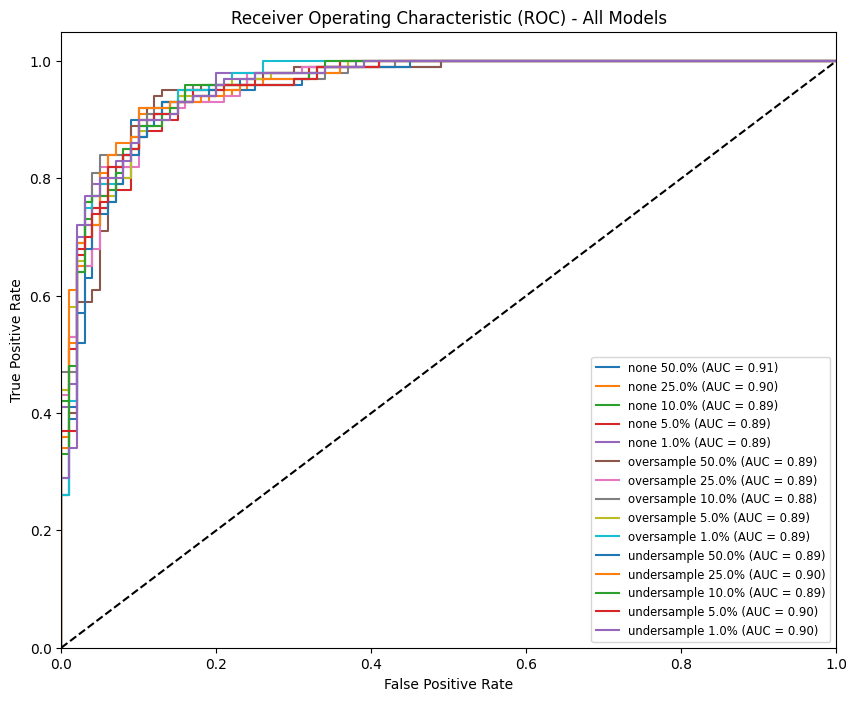

In [44]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from scipy import stats
import time

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def apply_sampling(strategy, X, y):
    if strategy == 'oversample':
        class_counts = np.bincount(y)
        smallest_class_size = np.min(class_counts[class_counts > 0])
        k_neighbors = max(1, min(smallest_class_size - 1, 5))
        try:
            sampler = SMOTE(k_neighbors=k_neighbors, random_state=42)
            X_res, y_res = sampler.fit_resample(X, y)
        except ValueError:
            print("Fallback: Resampling without SMOTE due to small class size.")
            X_res, y_res = resample(X, y, replace=False, n_samples=len(y), random_state=42)
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
        X_res, y_res = sampler.fit_resample(X, y)
    else:
        return X, y
    return X_res, y_res

def has_minimum_class_diversity(y, min_classes=2):
    return len(np.unique(y)) >= min_classes

def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    runtime = end_time - start_time
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    return accuracy, f1, roc_auc, runtime, fpr, tpr

classifiers = [
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('LR', LogisticRegression(max_iter=100, random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

ensemble = VotingClassifier(estimators=[
    (name, SelfTrainingClassifier(clf, criterion='k_best', k_best=200))
    for name, clf in classifiers
], voting='soft')

roc_data = []
results = []
label_ratios = [0.5,0.25,0.1,0.05,0.01]
strategies = ['none', 'oversample', 'undersample']

for strategy in strategies:
    for ratio in label_ratios:
        print(f"Processing {strategy} strategy with {ratio*100}% unlabeled data...")
        if ratio == 0:
            X_sampled, y_sampled = X_train_full, y_train_full
        else:
            X_labeled, _, y_labeled, _ = train_test_split(X_train_full, y_train_full, test_size=ratio, random_state=42, stratify=y_train_full)
            X_sampled, y_sampled = apply_sampling(strategy, X_labeled, y_labeled)

        if not has_minimum_class_diversity(y_sampled):
            print("Skipping training due to lack of class diversity.")
            continue

        ensemble.fit(X_sampled, y_sampled)
        accuracy, f1, roc_auc, runtime, fpr, tpr = evaluate_model(ensemble, X_test, y_test)

        results.append({
            'Strategy': strategy,
            'Label Ratio': ratio,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Runtime (s)': runtime
        })


        roc_data.append({'Strategy': strategy, 'Label Ratio': ratio, 'FPR': fpr, 'TPR': tpr, 'AUC': roc_auc})

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for data in roc_data:
    plt.plot(data['FPR'], data['TPR'], label=f"{data['Strategy']} {data['Label Ratio']*100}% (AUC = {data['AUC']:.2f})")
results_df = pd.DataFrame(results)
print(results_df)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - All Models')
plt.legend(loc="lower right", fontsize='small')
plt.show()


Processing none strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing SMOTE strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing SMOTE strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing SMOTE strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing SMOTE strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing SMOTE strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing BorderlineSMOTE strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing BorderlineSMOTE strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing BorderlineSMOTE strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing BorderlineSMOTE strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing BorderlineSMOTE strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing ADASYN strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing ADASYN strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing ADASYN strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing ADASYN strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing ADASYN strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing CombinedSMOTE_Under strategy with 50.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing CombinedSMOTE_Under strategy with 25.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing CombinedSMOTE_Under strategy with 10.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing CombinedSMOTE_Under strategy with 5.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing CombinedSMOTE_Under strategy with 1.0% unlabeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

               Strategy  Label Ratio  Accuracy  F1 Score   ROC AUC  \
0                  none         0.50    0.9700  0.983425  0.894444   
1                  none         0.25    0.9700  0.983425  0.894444   
2                  none         0.10    0.9650  0.980663  0.880556   
3                  none         0.05    0.9675  0.982019  0.893056   
4                  none         0.01    0.9650  0.980609  0.891667   
5                 SMOTE         0.50    0.9375  0.964639  0.898611   
6                 SMOTE         0.25    0.9500  0.971910  0.905556   
7                 SMOTE         0.10    0.9425  0.967468  0.912500   
8                 SMOTE         0.05    0.9400  0.966006  0.911111   
9                 SMOTE         0.01    0.9500  0.971751  0.927778   
10      BorderlineSMOTE         0.50    0.9400  0.966006  0.911111   
11      BorderlineSMOTE         0.25    0.9500  0.971831  0.916667   
12      BorderlineSMOTE         0.10    0.9475  0.970381  0.915278   
13      BorderlineSM

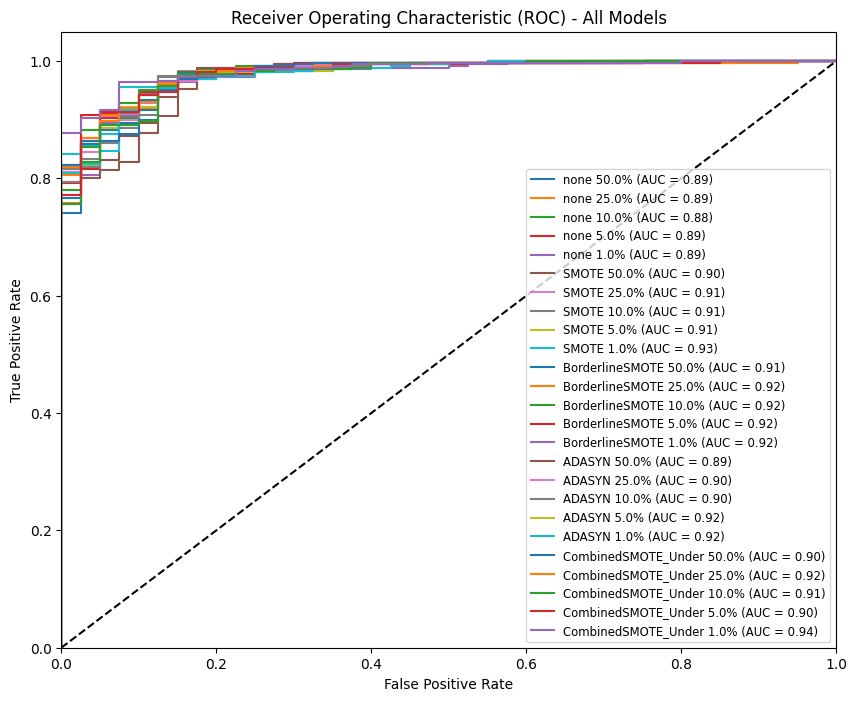

In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time

# Generate a synthetic dataset
X, y = make_classification(n_samples=2000, n_features=20, n_classes=2, weights=[0.1, 0.9], flip_y=0, random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def apply_advanced_sampling(strategy, X, y):
    if strategy == 'SMOTE':
        sampler = SMOTE(random_state=42)
    elif strategy == 'BorderlineSMOTE':
        sampler = BorderlineSMOTE(random_state=42, kind='borderline-1')
    elif strategy == 'ADASYN':
        sampler = ADASYN(random_state=42)
    elif strategy == 'CombinedSMOTE_Under':
        over_sampler = SMOTE(sampling_strategy=0.5, random_state=42)
        under_sampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
        sampler = Pipeline(steps=[('o', over_sampler), ('u', under_sampler)])
    else:
        return X, y

    X_res, y_res = sampler.fit_resample(X, y)
    return X_res, y_res

def has_minimum_class_diversity(y, min_classes=2):
    return len(np.unique(y)) >= min_classes

def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    runtime = end_time - start_time
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    return accuracy, f1, roc_auc, runtime, fpr, tpr

classifiers = [
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('LR', LogisticRegression(max_iter=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

ensemble = VotingClassifier(estimators=[
    (name, SelfTrainingClassifier(clf, criterion='k_best', k_best=20))
    for name, clf in classifiers
], voting='soft')

results = []
roc_data = []
label_ratios = [0.5,0.25,0.1,0.05,0.01]
strategies = ['none', 'SMOTE', 'BorderlineSMOTE', 'ADASYN', 'CombinedSMOTE_Under']

for strategy in strategies:
    for ratio in label_ratios:
        print(f"Processing {strategy} strategy with {ratio*100}% unlabeled data...")
        if ratio == 0:
            X_sampled, y_sampled = X_train_full, y_train_full
        else:
            X_labeled, _, y_labeled, _ = train_test_split(X_train_full, y_train_full, test_size=ratio, random_state=42, stratify=y_train_full)
            X_sampled, y_sampled = apply_advanced_sampling(strategy, X_labeled, y_labeled)

        if not has_minimum_class_diversity(y_sampled):
            print("Skipping training due to lack of class diversity.")
            continue

        ensemble.fit(X_sampled, y_sampled)
        accuracy, f1, roc_auc, runtime, fpr, tpr = evaluate_model(ensemble, X_test, y_test)

        results.append({
            'Strategy': strategy,
            'Label Ratio': ratio,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Runtime (s)': runtime
        })

        roc_data.append({'Strategy': strategy, 'Label Ratio': ratio, 'FPR': fpr, 'TPR': tpr, 'AUC': roc_auc})

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for data in roc_data:
    plt.plot(data['FPR'], data['TPR'], label=f"{data['Strategy']} {data['Label Ratio']*100}% (AUC = {data['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - All Models')
plt.legend(loc="lower right", fontsize='small')
plt.show()


In [ ]:
.........................................

#   semi-supervised ensemble with confidence threshold with k_best and sampling_strategy


Processing none strategy with 50.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 25.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 10.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 5.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing none strategy with 1.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 50.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 25.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 10.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 5.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing oversample strategy with 1.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 50.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 25.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 10.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 5.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Processing undersample strategy with 1.0% labeled data...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

       Strategy  Label Ratio  Accuracy  F1 Score   ROC AUC   Runtime
0          none         0.50     0.940  0.647059  0.843841  0.013169
1          none         0.25     0.950  0.705882  0.877095  0.014856
2          none         0.10     0.950  0.705882  0.880287  0.015711
3          none         0.05     0.955  0.742857  0.924448  0.014460
4          none         0.01     0.950  0.705882  0.907688  0.016123
5    oversample         0.50     0.950  0.736842  0.841447  0.014381
6    oversample         0.25     0.940  0.666667  0.865124  0.009654
7    oversample         0.10     0.950  0.705882  0.897845  0.011802
8    oversample         0.05     0.950  0.722222  0.899175  0.014684
9    oversample         0.01     0.955  0.742857  0.913541  0.009141
10  undersample         0.50     0.835  0.507463  0.910881  0.008458
11  undersample         0.25     0.900  0.583333  0.820165  0.009372
12  undersample         0.10     0.870  0.535714  0.885874  0.010332
13  undersample         0.05     0

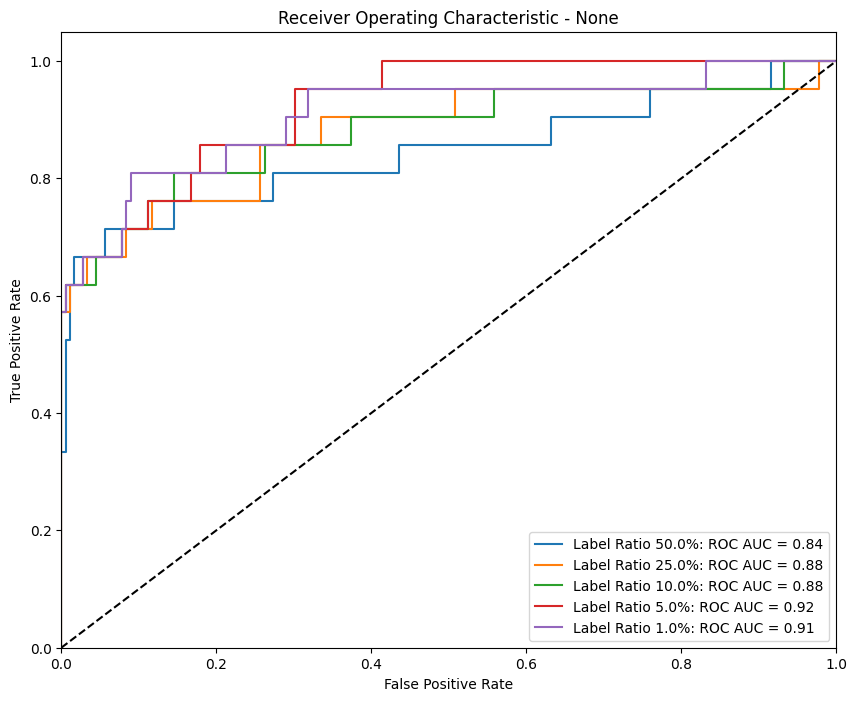

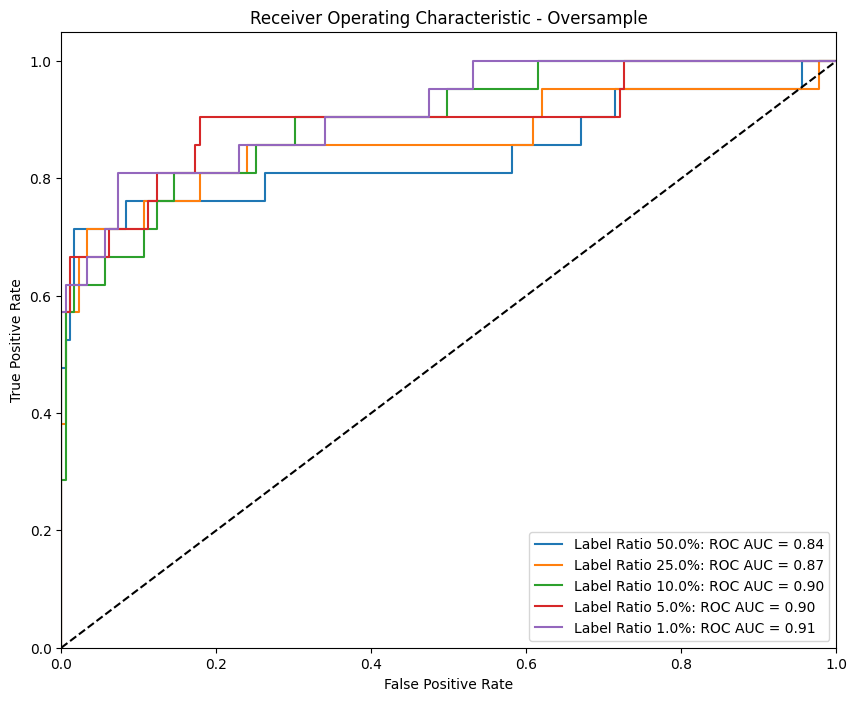

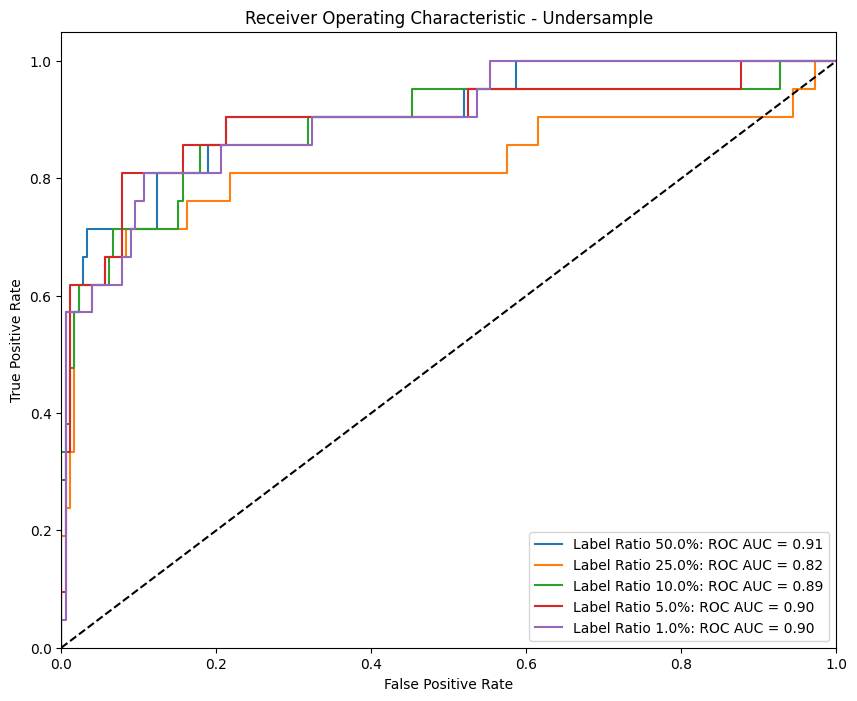

In [46]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import time

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.9, 0.1], random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def apply_sampling(strategy, X, y):
    if strategy == 'oversample':
        try:
            sampler = SMOTE(sampling_strategy=0.2, random_state=42)
            X_res, y_res = sampler.fit_resample(X, y)
        except ValueError:
            print("Fallback: Resampling without SMOTE due to small class size.")
            X_res, y_res = X, y
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
        X_res, y_res = sampler.fit_resample(X, y)
    else:
        return X, y
    return X_res, y_res

def has_minimum_class_diversity(y, min_classes=2):
    return len(np.unique(y)) >= min_classes

def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    runtime = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return accuracy, f1, roc_auc, runtime

classifiers = [
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('LR', LogisticRegression(max_iter=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

ensemble = VotingClassifier(estimators=[
    (name, SelfTrainingClassifier(clf, criterion='k_best', k_best=50))
    for name, clf in classifiers
], voting='soft')

results = []
roc_data = {
    'none': [],
    'oversample': [],
    'undersample': []
}
label_ratios = [0.5, 0.25, 0.1, 0.05, 0.01]
strategies = ['none', 'oversample', 'undersample']

for strategy in strategies:
    for ratio in label_ratios:
        print(f"Processing {strategy} strategy with {ratio*100}% labeled data...")
        if ratio == 0:
            X_sampled, y_sampled = X_train_full, y_train_full
        else:
            X_labeled, _, y_labeled, _ = train_test_split(X_train_full, y_train_full, test_size=ratio, random_state=42, stratify=y_train_full)
            X_sampled, y_sampled = apply_sampling(strategy, X_labeled, y_labeled)

        if not has_minimum_class_diversity(y_sampled):
            print("Skipping training due to lack of class diversity.")
            continue

        ensemble.fit(X_sampled, y_sampled)
        accuracy, f1, roc_auc, runtime = evaluate_model(ensemble, X_test, y_test)

        results.append({
            'Strategy': strategy,
            'Label Ratio': ratio,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Runtime': runtime
        })

        fpr, tpr, _ = roc_curve(y_test, ensemble.predict_proba(X_test)[:, 1])
        roc_data[strategy].append((fpr, tpr, roc_auc, ratio))

results_df = pd.DataFrame(results)
print(results_df)

# Plotting ROC curves for each strategy
for strategy, data in roc_data.items():
    plt.figure(figsize=(10, 8))
    for fpr, tpr, roc_auc, ratio in data:
        plt.plot(fpr, tpr, label=f'Label Ratio {ratio*100}%: ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {strategy.capitalize()}')
    plt.legend(loc="lower right")
    plt.show()


Evaluating on the original skewed dataset...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Evaluating on the dataset after oversample...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

Evaluating on the dataset after undersample...


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:217: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings

      Strategy  Accuracy  F1 Score   ROC AUC   Runtime
0     Baseline     0.960  0.764706  0.908486  0.010627
1   Oversample     0.960  0.777778  0.913807  0.009546
2  Undersample     0.895  0.571429  0.917531  0.014405


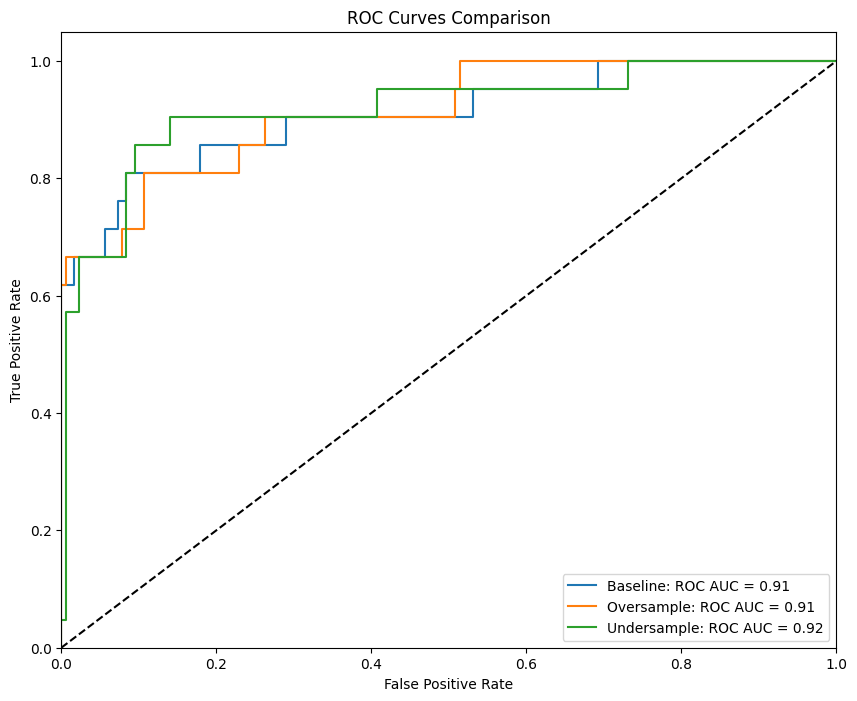

In [48]:

# Function to evaluate models and return performance metrics and runtime
def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    runtime = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return accuracy, f1, roc_auc, runtime

# Initialize a list to store results for all evaluations
all_results = []

# Initialize a dictionary to store ROC data for plotting
roc_curves = {}

# Evaluate models on the original skewed dataset as a baseline
print("Evaluating on the original skewed dataset...")
X_train, y_train = X_train_full, y_train_full  # No sampling applied for baseline
ensemble.fit(X_train, y_train)
metrics = evaluate_model(ensemble, X_test, y_test)
all_results.append(('Baseline', metrics[0], metrics[1], metrics[2], metrics[3]))
fpr, tpr, _ = roc_curve(y_test, ensemble.predict_proba(X_test)[:, 1])
roc_curves['Baseline'] = (fpr, tpr, metrics[2])

# Evaluate models on oversampled and undersampled datasets
for strategy in ['oversample', 'undersample']:
    print(f"Evaluating on the dataset after {strategy}...")
    X_resampled, y_resampled = apply_sampling(strategy, X_train_full, y_train_full)
    ensemble.fit(X_resampled, y_resampled)
    metrics = evaluate_model(ensemble, X_test, y_test)
    all_results.append((strategy.capitalize(), metrics[0], metrics[1], metrics[2], metrics[3]))
    fpr, tpr, _ = roc_curve(y_test, ensemble.predict_proba(X_test)[:, 1])
    roc_curves[strategy.capitalize()] = (fpr, tpr, metrics[2])

# Display results
results_df = pd.DataFrame(all_results, columns=['Strategy', 'Accuracy', 'F1 Score', 'ROC AUC', 'Runtime'])
print(results_df)

# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))
for strategy, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{strategy}: ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()
